In [29]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedGroupKFold, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.preprocessing import StandardScaler

In [42]:
# Load dataset, add column for patient ID, and scale numeric columns
df = pd.read_csv("../data_raw/parkinsons.csv")
df['patient_id'] = df['name'].str[:12]

# Define features and target
X = df.drop(columns=["patient_id", "status", "name"])  # Feature matrix
y = df["status"]  # Labels
patient_ids = df["patient_id"]  # Patient grouping

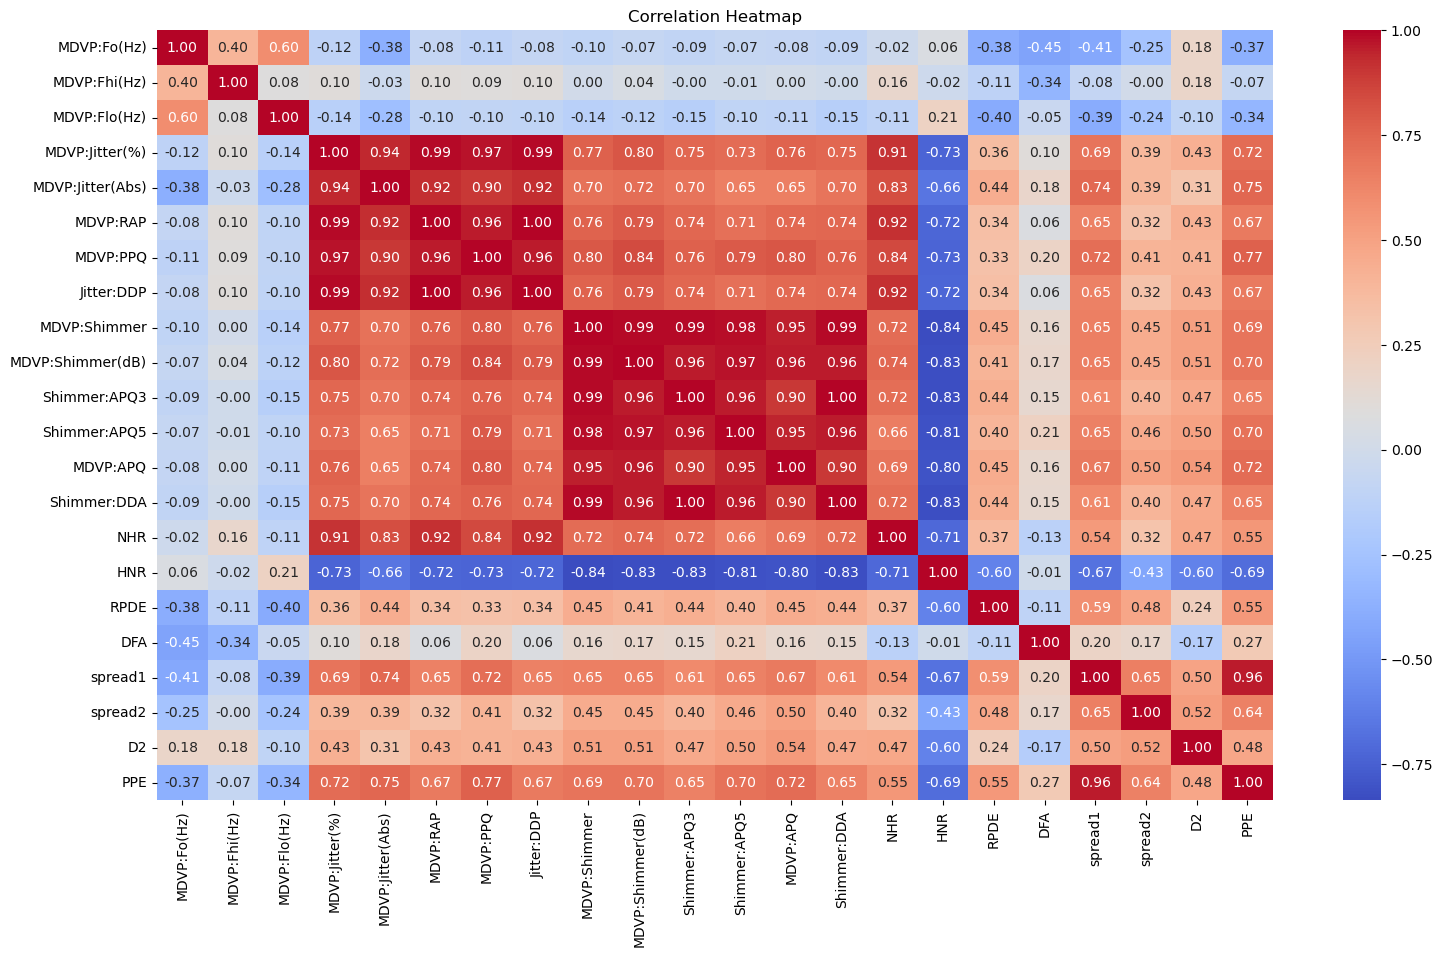

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Plot heatmap
plt.figure(figsize=(18, 10))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()


In [44]:
# Scale training dataset
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [45]:
# Use Stratified Group K-Fold (for imbalanced data)
sgkf = StratifiedGroupKFold(n_splits=5)  # 5-fold stratified CV

# Define models
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42)
}

# Iterate over models to find best one
# Note: deep learning is not being tested due to small data size
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    accuracies = []
    auc_scores = []
    all_y_true = []
    all_y_pred = []
    
    for train_idx, test_idx in sgkf.split(X, y, groups=patient_ids):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Train model
        model.fit(X_train, y_train)
        
        # Predict
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test)
        
        # Store metrics
        accuracies.append(accuracy_score(y_test, y_pred))
        auc_scores.append(roc_auc_score(y_test, y_prob))
        all_y_true.extend(y_test)
        all_y_pred.extend(y_pred)
    
    # Print results
    print(f"{model_name} - Average Accuracy: {np.mean(accuracies):.4f}")
    print(f"{model_name} - Average AUC: {np.mean(auc_scores):.4f}")
    print("\nFinal Classification Report:")
    print(classification_report(all_y_true, all_y_pred))


Training RandomForest...
RandomForest - Average Accuracy: 0.7951
RandomForest - Average AUC: 0.8721

Final Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.38      0.47        48
           1       0.82      0.93      0.87       147

    accuracy                           0.79       195
   macro avg       0.72      0.65      0.67       195
weighted avg       0.77      0.79      0.77       195


Training SVM...
SVM - Average Accuracy: 0.8237
SVM - Average AUC: 0.8113

Final Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.33      0.48        48
           1       0.82      0.98      0.89       147

    accuracy                           0.82       195
   macro avg       0.83      0.66      0.68       195
weighted avg       0.82      0.82      0.79       195


Training XGBoost...
XGBoost - Average Accuracy: 0.7992
XGBoost - Average AUC: 0.8182

Final Classification Rep

In [46]:
# logistic regression performs the best

# Tune hyperparameters
# Define Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, solver="liblinear", random_state=42)

# Define hyperparameter grid
param_grid = {
    "C": np.logspace(-4, 4, 20),  # Regularization strength
    "penalty": ["l1", "l2"],  # Type of regularization
    "class_weight": ["balanced", None]
}

# Perform Randomized Search CV
random_search = RandomizedSearchCV(log_reg, param_grid, n_iter=20, scoring="accuracy", 
                                   cv=5, random_state=42, n_jobs=-1)
random_search.fit(X, y)

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=1000, random_state=42,
                                                solver='liblinear'),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                                        'class_weight': ['balanced', None],
                                        'penalty': ['l1', 'l2']},
                   random_state=42, scoring='accuracy')

In [47]:
# Best model from hyperparameter tuning
best_log_reg = random_search.best_estimator_
print("Best Parameters:", random_search.best_params_)

# Evaluate best model using Stratified Group K-Fold
accuracies = []
auc_scores = []
all_y_true = []
all_y_pred = []

for train_idx, test_idx in sgkf.split(X, y, groups=patient_ids):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Train best model
    best_log_reg.fit(X_train, y_train)
    
    # Predict
    y_pred = best_log_reg.predict(X_test)
    y_prob = best_log_reg.predict_proba(X_test)[:, 1]
    
    # Store metrics
    accuracies.append(accuracy_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_prob))
    all_y_true.extend(y_test)
    all_y_pred.extend(y_pred)

# Print final results
print(f"Logistic Regression - Average Accuracy: {np.mean(accuracies):.4f}")
print(f"Logistic Regression - Average AUC: {np.mean(auc_scores):.4f}")
print("\nFinal Classification Report:")
print(classification_report(all_y_true, all_y_pred))

Best Parameters: {'penalty': 'l1', 'class_weight': None, 'C': np.float64(0.08858667904100823)}
Logistic Regression - Average Accuracy: 0.7945
Logistic Regression - Average AUC: 0.9031

Final Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.48      0.53        48
           1       0.84      0.89      0.86       147

    accuracy                           0.79       195
   macro avg       0.71      0.69      0.70       195
weighted avg       0.78      0.79      0.78       195



In [48]:
best_log_reg.fit(X, y)  # Best model

LogisticRegression(C=np.float64(0.08858667904100823), max_iter=1000,
                   penalty='l1', random_state=42, solver='liblinear')